[*********************100%%**********************]  2 of 2 completed


Correlation between Beta and Volatility: 0.36
Variance Inflation Factors (VIF):
       Feature        VIF
0       const  13.628902
1        Beta   1.152243
2  Volatility   1.152243
Correlation between Beta and Orthogonalized Volatility: -0.00


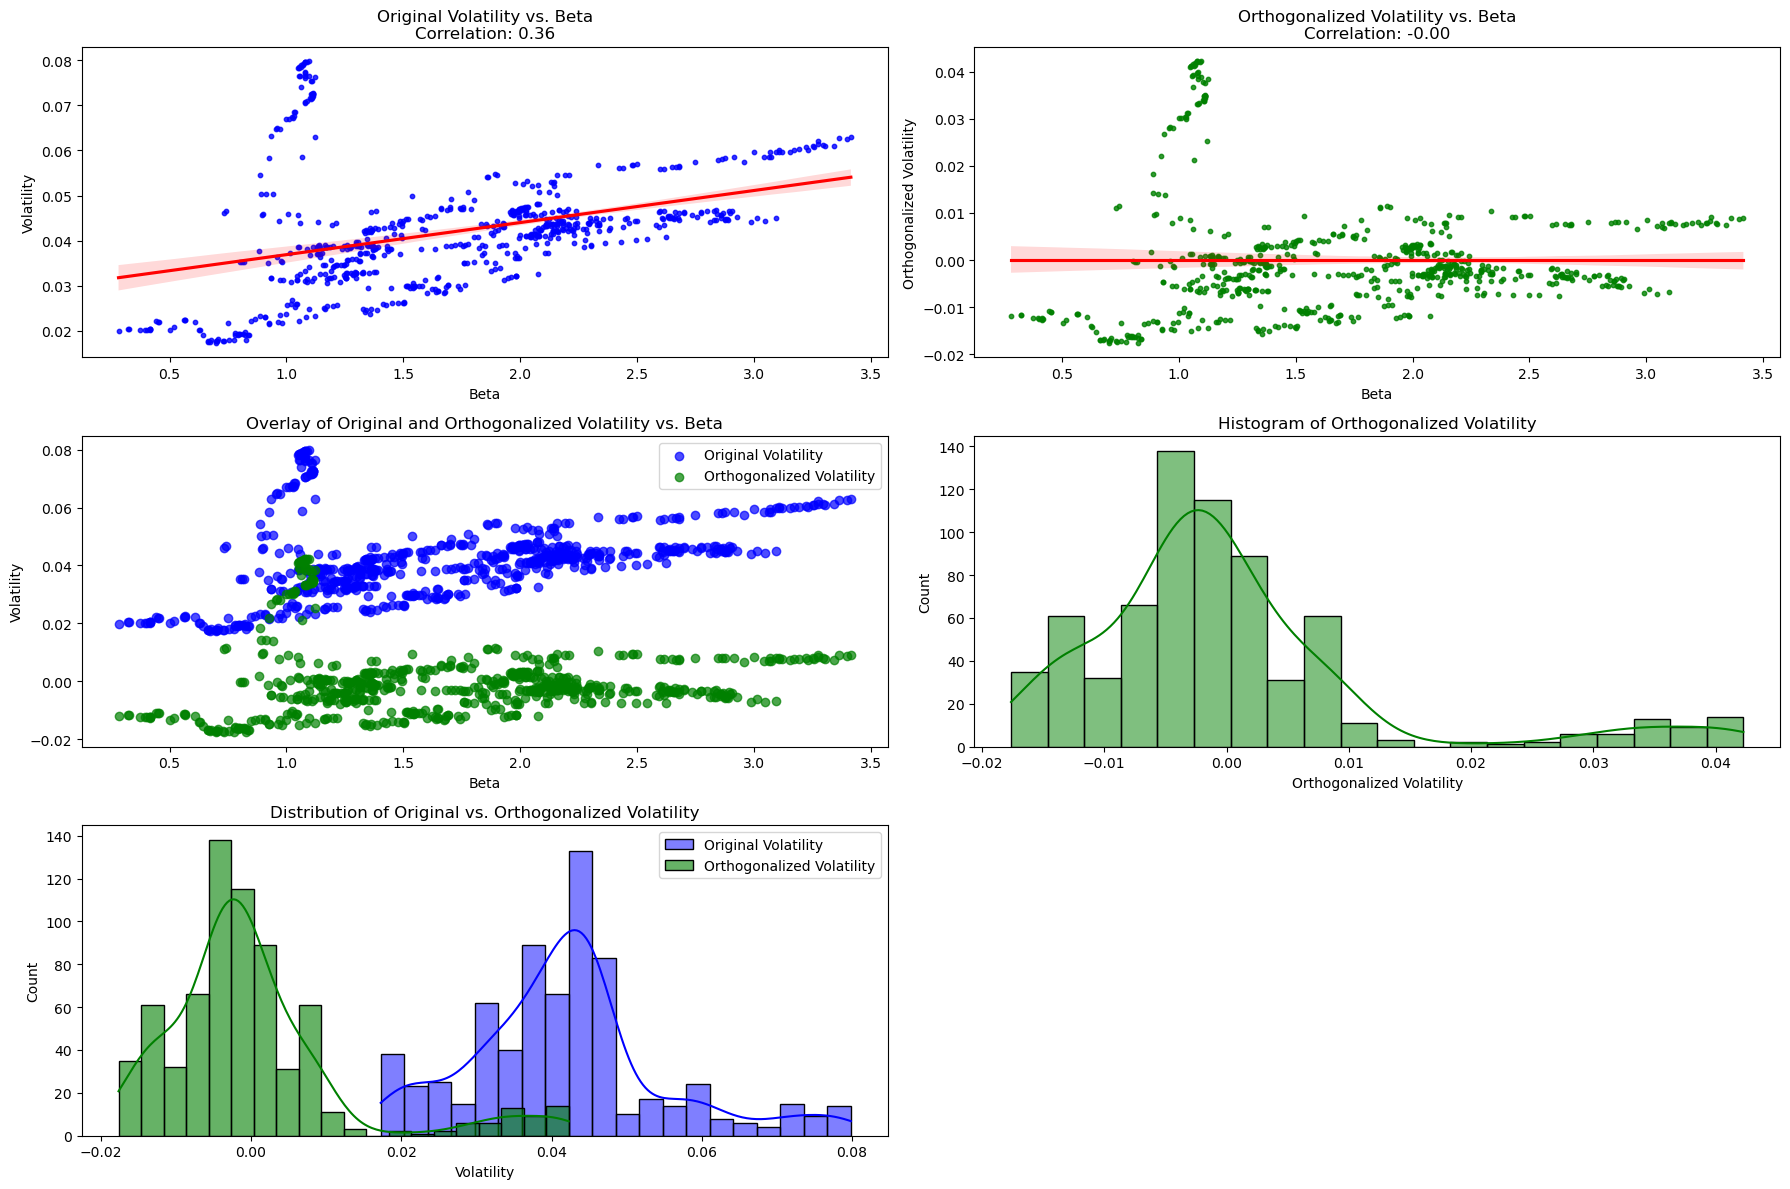

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Retrieve Tesla (TSLA) and S&P 500 (SPX) data from Yahoo Finance
tickers = ["TSLA", "^GSPC"]
start = "2020-01-01"
end = "2023-01-01"
data = yf.download(tickers, start=start, end=end)['Adj Close']
data.columns = ["TSLA_Close", "SPX_Close"]

# Calculate daily returns and drop NaNs
data['TSLA_Return'] = data['TSLA_Close'].pct_change()
data['SPX_Return'] = data['SPX_Close'].pct_change()
data = data.dropna()

# Define rolling window size (e.g., 60 days) for calculating rolling beta and volatility
window_size = 60

# Step 2: Calculate rolling Beta and Volatility for TSLA
betas = []
volatilities = []

for i in range(len(data) - window_size):
    # Get the data window
    window_data = data.iloc[i:i + window_size]
    
    # Calculate beta by regressing TSLA returns on SPX returns for this window
    X = sm.add_constant(window_data['SPX_Return'])
    model = sm.OLS(window_data['TSLA_Return'], X).fit()
    beta = model.params.iloc[1]  # Use `.iloc[1]` to avoid FutureWarning
    betas.append(beta)
    
    # Calculate volatility as the standard deviation of TSLA returns within the window
    volatility = np.std(window_data['TSLA_Return'])
    volatilities.append(volatility)

# Step 3: Create a DataFrame for analysis
df = pd.DataFrame({'Beta': betas, 'Volatility': volatilities})

# Replace inf values with NaN and drop any rows with NaN values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Check for multicollinearity
correlation = df['Beta'].corr(df['Volatility'])
print(f"Correlation between Beta and Volatility: {correlation:.2f}")

# Calculate VIF
X_vif = sm.add_constant(df[['Beta', 'Volatility']])
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("Variance Inflation Factors (VIF):\n", vif_data)

# Step 4: Orthogonalize Volatility with Respect to Beta
X_beta = sm.add_constant(df['Beta'])
model_orthogonalize = sm.OLS(df['Volatility'], X_beta).fit()
df['Orthogonalized Volatility'] = model_orthogonalize.resid

# Re-check correlation after orthogonalization
correlation_orthogonalized = df['Beta'].corr(df['Orthogonalized Volatility'])
print(f"Correlation between Beta and Orthogonalized Volatility: {correlation_orthogonalized:.2f}")

# Step 5: Plot all graphs and save as PNG

# Original vs. Orthogonalized Volatility with Regression Line
plt.figure(figsize=(18, 12))

plt.subplot(3, 2, 1)
sns.regplot(x=df['Beta'], y=df['Volatility'], scatter_kws={'color': 'blue', 's': 10}, line_kws={'color': 'red'})
plt.xlabel("Beta")
plt.ylabel("Volatility")
plt.title(f"Original Volatility vs. Beta\nCorrelation: {correlation:.2f}")
plt.savefig("Original_Volatility_vs_Beta.png")

plt.subplot(3, 2, 2)
sns.regplot(x=df['Beta'], y=df['Orthogonalized Volatility'], scatter_kws={'color': 'green', 's': 10}, line_kws={'color': 'red'})
plt.xlabel("Beta")
plt.ylabel("Orthogonalized Volatility")
plt.title(f"Orthogonalized Volatility vs. Beta\nCorrelation: {correlation_orthogonalized:.2f}")
plt.savefig("Orthogonalized_Volatility_vs_Beta.png")

# Overlay Plot for Comparison
plt.subplot(3, 2, 3)
plt.scatter(df['Beta'], df['Volatility'], alpha=0.7, color="blue", label="Original Volatility")
plt.scatter(df['Beta'], df['Orthogonalized Volatility'], alpha=0.7, color="green", label="Orthogonalized Volatility")
plt.xlabel("Beta")
plt.ylabel("Volatility")
plt.title("Overlay of Original and Orthogonalized Volatility vs. Beta")
plt.legend()
plt.savefig("Overlay_Original_Orthogonalized.png")

# Histogram of Residuals (Orthogonalized Volatility)
plt.subplot(3, 2, 4)
sns.histplot(df['Orthogonalized Volatility'], kde=True, color="green", bins=20)
plt.xlabel("Orthogonalized Volatility")
plt.title("Histogram of Orthogonalized Volatility")
plt.savefig("Histogram_Orthogonalized_Volatility.png")

# Original Volatility and Orthogonalized Volatility Distributions
plt.subplot(3, 2, 5)
sns.histplot(df['Volatility'], kde=True, color="blue", bins=20, label="Original Volatility")
sns.histplot(df['Orthogonalized Volatility'], kde=True, color="green", bins=20, label="Orthogonalized Volatility", alpha=0.6)
plt.xlabel("Volatility")
plt.title("Distribution of Original vs. Orthogonalized Volatility")
plt.legend()
plt.savefig("Distribution_Original_vs_Orthogonalized.png")

plt.tight_layout()
plt.show()